In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs 

from torch.utils.data import TensorDataset
from src.data import get_dataloaders, get_retain_forget_datasets
from src.train import train
from src.eval import evaluate
from src.forget import sample_from_exact_marginal, estimate_marginal_kl_distance, forget
# from src.utils import melt_model
from src.loss import L2RegularizedCrossEntropyLoss

import math

Using device: cuda:0


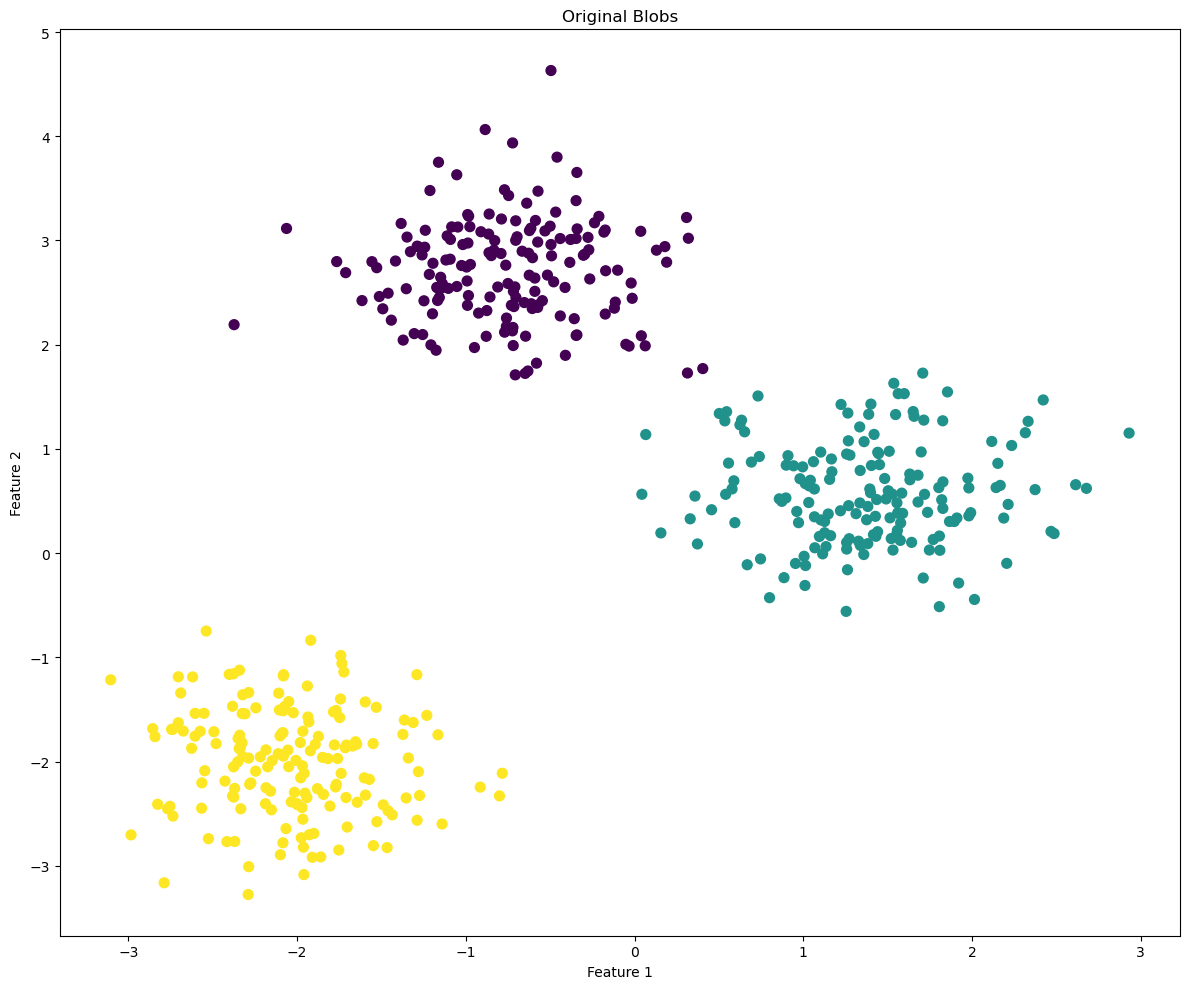

In [2]:
#######################################
# 1) DEVICE SETUP
#######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#######################################
# 2) SYNTHETIC DATASET (MULTICLASS)
#######################################
# Generate synthetic data (2D, 3 classes)
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=0.5, center_box=(-3, 3), random_state=42)
plt.figure(figsize=(12, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50)
plt.title('Original Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X, y)

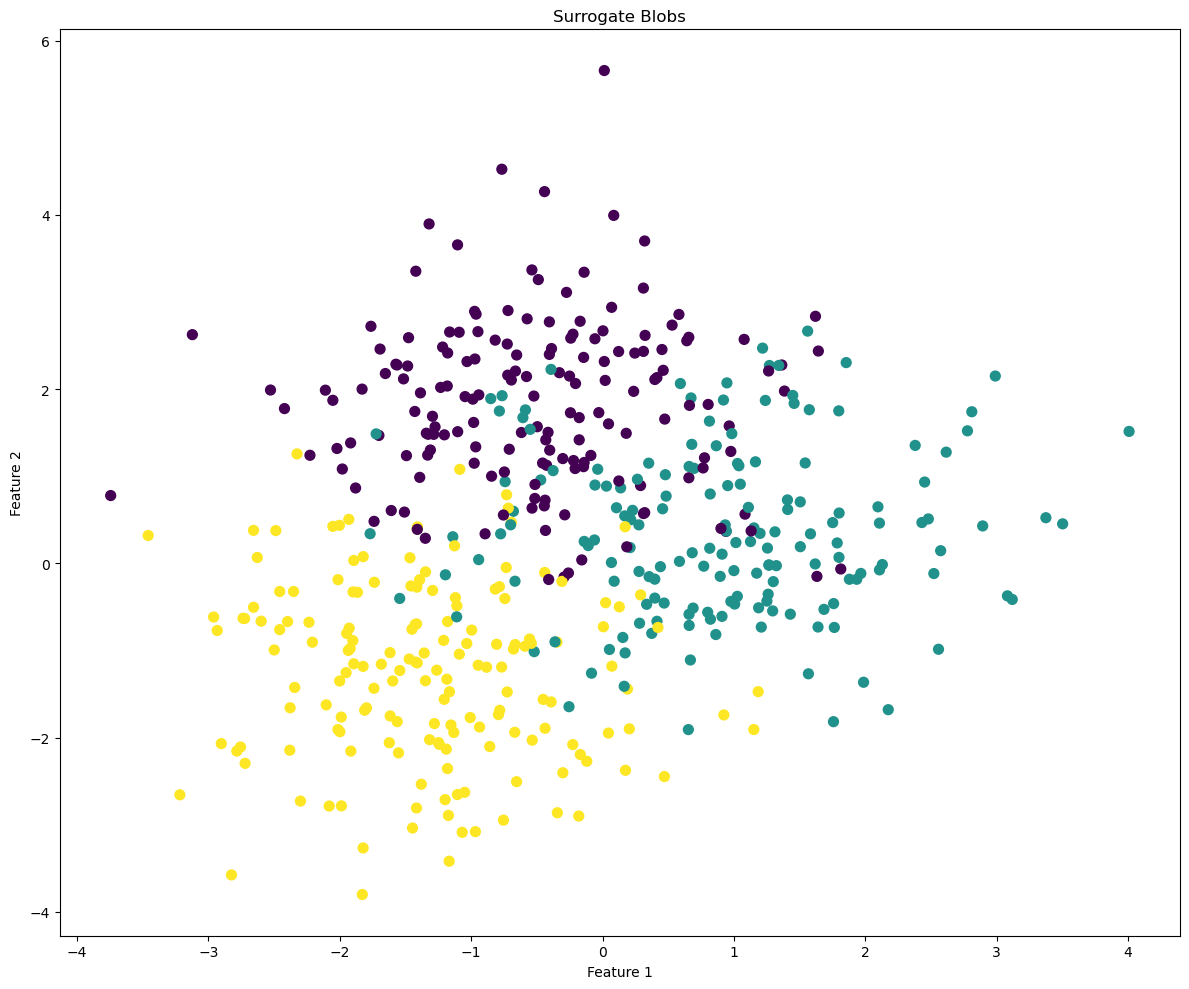

In [3]:
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=1, center_box=(-2, 2), random_state=42)
# Plot the original and normalized blobs
plt.figure(figsize=(12, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50)
plt.title('Surrogate Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
surrogate_dataset = TensorDataset(X, y)

In [5]:
# set datasets
train_dataset, test_dataset = get_retain_forget_datasets(dataset, 0.1)
retain_dataset, forget_dataset = get_retain_forget_datasets(train_dataset, 0.05)
train_loader, test_loader = get_dataloaders([train_dataset, test_dataset], batch_size=256)
retain_loader, forget_loader = get_dataloaders([retain_dataset, forget_dataset], batch_size=256)
surrogate_loader = get_dataloaders(surrogate_dataset, batch_size=256) 

In [6]:

#######################################
# 3) MLP CLASSIFIER
#######################################
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 3)  # Output layer: 3 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model, optimizer, and loss function
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = L2RegularizedCrossEntropyLoss(l2_lambda=0.1)

In [7]:
def log_eval(model, train_loader, val_loader, retain_loader, forget_loader, surr_loader, criterion, device):
    train_acc = evaluate(train_loader, model, criterion, device=device, log=True)
    test_acc = evaluate(val_loader, model, criterion, device=device, log=True)
    retain_acc = evaluate(retain_loader, model, criterion, device=device, log=True)
    forget_acc = evaluate(forget_loader, model, criterion, device=device, log=True)
    surr_acc = evaluate(surr_loader, model, criterion, device=device, log=True)
    print('train: {}, test: {}, retain: {}, forget: {}, surrogate:{}'.format(train_acc, test_acc, retain_acc, forget_acc, surr_acc))

In [8]:
train(train_loader, test_loader, model, criterion, optimizer, num_epoch=100, device=device)
log_eval(model, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)

eval: 100%|██████████| 2/2 [00:00<00:00, 440.21batch/s, acc=0.818, loss=1.15]

train: 0.9866666666666667, test: 0.96, retain: 0.9883177570093458, forget: 0.9545454545454546, surrogate:0.818


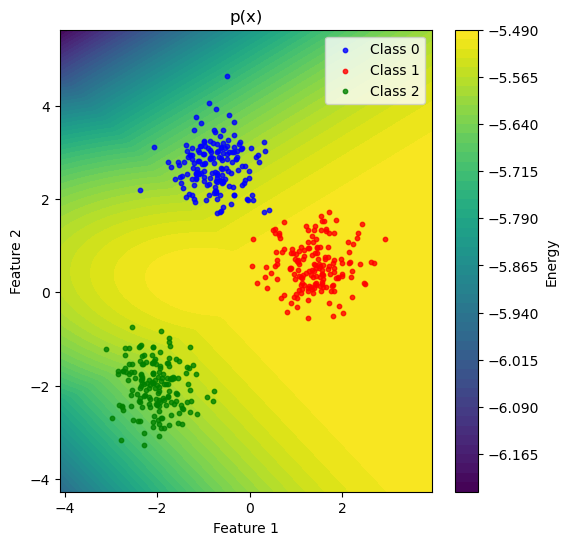

In [9]:
#######################################
# VISUALIZE ENERGY
#######################################
# Create a grid of points in the feature space
# model = model.to(device)
X, y = dataset.tensors
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min().cpu() - 1.0, X[:, 0].max().cpu() + 1.0, 100),
    np.linspace(X[:, 1].min().cpu() - 1.0, X[:, 1].max().cpu() + 1.0, 100)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

# Compute predictions and energy
T = 5
feature_1_range = (-5, 3) 
feature_2_range = (-4, 4)

with torch.no_grad():
    logits = model(grid)
    energy = -1 * T * torch.logsumexp(logits / T, dim=1)
    penalty_mask = (
        (grid[:, 0] >= feature_1_range[0]) & (grid[:, 0] <= feature_1_range[1]) &
        (grid[:, 1] >= feature_2_range[0]) & (grid[:, 1] <= feature_2_range[1])
    )
    energy[penalty_mask] += 0
    energy = energy.to('cpu').numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.title("p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
model = model.to('cpu')
grid = grid.to('cpu')

In [10]:
smodel = MLP()
smodel = smodel.to(device)
optimizer = torch.optim.Adam(smodel.parameters(), lr=0.01)
train(surrogate_loader, test_loader, smodel, criterion, optimizer, num_epoch=100, device=device)
log_eval(smodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)

eval: 100%|██████████| 2/2 [00:00<00:00, 483.33batch/s, acc=0.634, loss=1.09]


train: 0.6644444444444444, test: 0.68, retain: 0.6635514018691588, forget: 0.6818181818181818, surrogate:0.634


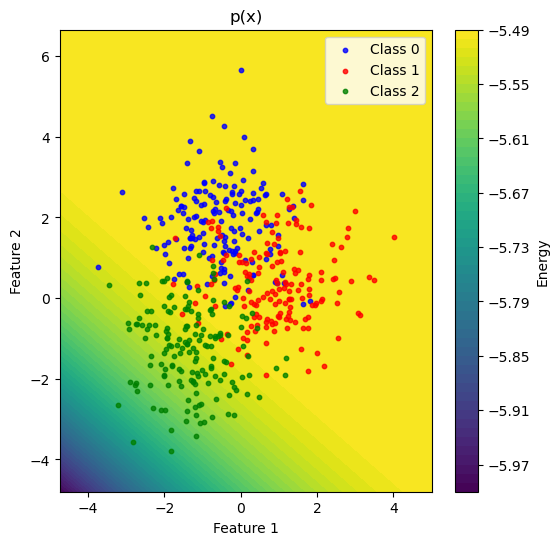

In [11]:
#######################################
# VISUALIZE ENERGY
#######################################
# Create a grid of points in the feature space
# smodel = smodel.to(device)
X, y = surrogate_dataset.tensors
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min().cpu() - 1.0, X[:, 0].max().cpu() + 1.0, 100),
    np.linspace(X[:, 1].min().cpu() - 1.0, X[:, 1].max().cpu() + 1.0, 100)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

# Compute predictions and energy
T = 5
feature_1_range = (-3.5, 2.5) 
feature_2_range = (-3, 3)

with torch.no_grad():
    logits = smodel(grid)
    energy = -1 * T * torch.logsumexp(logits / T, dim=1)
    penalty_mask = (
        (grid[:, 0] >= feature_1_range[0]) & (grid[:, 0] <= feature_1_range[1]) &
        (grid[:, 1] >= feature_2_range[0]) & (grid[:, 1] <= feature_2_range[1])
    )
    energy[penalty_mask] += 0
    energy = energy.to('cpu').numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), color="red", s=10, alpha=0.8, label="Class 1")
plt.scatter(X[y == 2, 0].cpu(), X[y == 2, 1].cpu(), color="green", s=10, alpha=0.8, label="Class 2")
plt.title("p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
smodel = smodel.to('cpu')
grid = grid.to('cpu')

Generating samples with size [2]...
#########################################
sample 1 generated
#########################################
#########################################
sample 2 generated
#########################################
#########################################
sample 3 generated
#########################################
#########################################
sample 4 generated
#########################################
#########################################
sample 5 generated
#########################################
#########################################
sample 6 generated
#########################################
#########################################
sample 7 generated
#########################################
#########################################
sample 8 generated
#########################################
#########################################
sample 9 generated
#########################################
#####################################

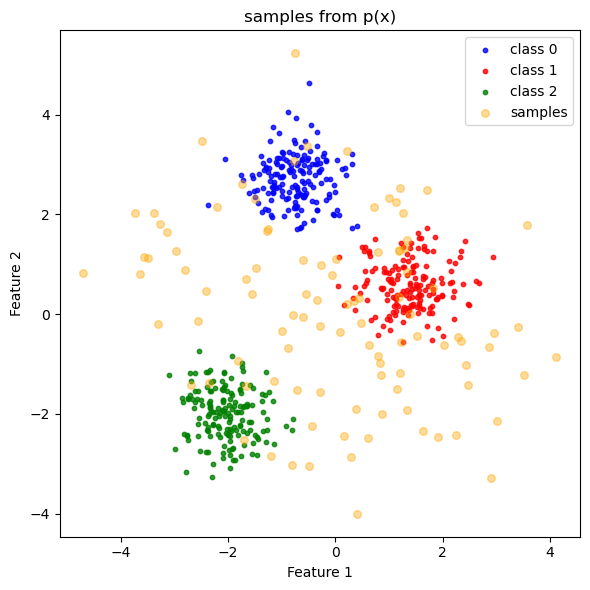

In [12]:
# GENERATE SAMPLES FROM THE EXACT TRAINED MODEL
# Define the min and max values for each feature
min_values = torch.tensor([[-2, -2]])  # Minimum for each feature
max_values = torch.tensor([[2, 2]])  # Maximum for each feature

# Concatenate min and max values along the last dimension
range_tensor = torch.stack([min_values, max_values], dim=-1).to(device)
model = model.to(device)
egensample_loader = sample_from_exact_marginal(model, 100, [2], 256, input_range=[-2, 2], range_tensor=range_tensor, range_penalty=3)
model = model.to('cpu')
(samples, ) = egensample_loader.dataset.tensors
X, y = dataset.tensors
# Plot energy landscape for class 0
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="class 1")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10, alpha=0.8, label="class 2")
plt.scatter(samples[:, 0], samples[:, 1], label="samples", s=30, alpha=0.4, color="orange")
plt.title("samples from p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

Generating samples with size [2]...
#########################################
sample 1 generated
#########################################
#########################################
sample 2 generated
#########################################
#########################################
sample 3 generated
#########################################
#########################################
sample 4 generated
#########################################
#########################################
sample 5 generated
#########################################
#########################################
sample 6 generated
#########################################
#########################################
sample 7 generated
#########################################
#########################################
sample 8 generated
#########################################
#########################################
sample 9 generated
#########################################
#####################################

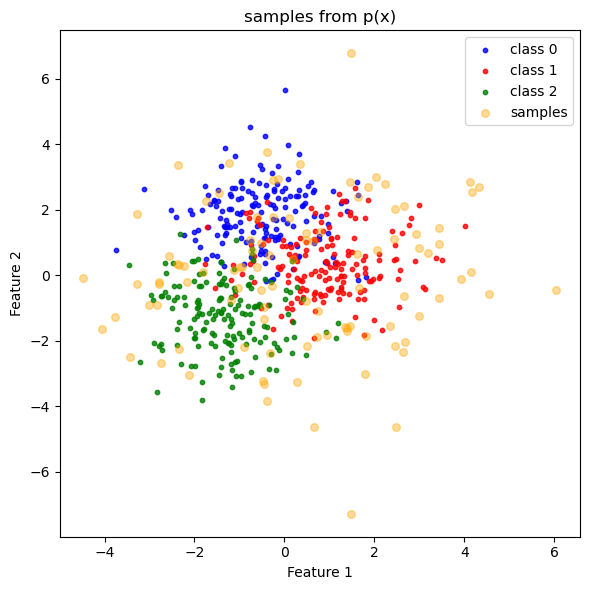

In [13]:
# GENERATE SAMPLES FROM THE SURROGATE TRAINED MODEL
# Define the min and max values for each feature
min_values = torch.tensor([[-3.5, -3]])  # Minimum for each feature
max_values = torch.tensor([[2.5, 3]])  # Maximum for each feature

# Concatenate min and max values along the last dimension
range_tensor = torch.stack([min_values, max_values], dim=-1).to(device)
smodel = smodel.to(device)
sgensample_loader = sample_from_exact_marginal(smodel, 100, [2], 256, input_range=[-3, 3], range_tensor=range_tensor, range_penalty=3)
smodel = smodel.to('cpu')
(samples, ) = sgensample_loader.dataset.tensors
X, y = surrogate_dataset.tensors
# Plot energy landscape for class 0
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="class 1")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10, alpha=0.8, label="class 2")
plt.scatter(samples[:, 0], samples[:, 1], label="samples", s=30, alpha=0.4, color="orange")
plt.title("samples from p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
_, kl_distance_s = estimate_marginal_kl_distance(surrogate_loader, egensample_loader, device)

Epoch 1, DV KL: 0.0118
Epoch 2, DV KL: 0.0188
Epoch 3, DV KL: 0.0259
Epoch 4, DV KL: 0.0328
Epoch 5, DV KL: 0.0394
Epoch 6, DV KL: 0.0459
Epoch 7, DV KL: 0.0523
Epoch 8, DV KL: 0.0585
Epoch 9, DV KL: 0.0647
Epoch 10, DV KL: 0.0705
Epoch 11, DV KL: 0.0766
Epoch 12, DV KL: 0.0819
Epoch 13, DV KL: 0.0872
Epoch 14, DV KL: 0.0922
Epoch 15, DV KL: 0.0973
Epoch 16, DV KL: 0.1021
Epoch 17, DV KL: 0.1073
Epoch 18, DV KL: 0.1116
Epoch 19, DV KL: 0.1164
Epoch 20, DV KL: 0.1205
Epoch 21, DV KL: 0.1251
Epoch 22, DV KL: 0.1292
Epoch 23, DV KL: 0.1331
Epoch 24, DV KL: 0.1375
Epoch 25, DV KL: 0.1412
Epoch 26, DV KL: 0.1456
Epoch 27, DV KL: 0.1493
Epoch 28, DV KL: 0.1529
Epoch 29, DV KL: 0.1568
Epoch 30, DV KL: 0.1604
Epoch 31, DV KL: 0.1635
Epoch 32, DV KL: 0.1668
Epoch 33, DV KL: 0.1699
Epoch 34, DV KL: 0.1733
Epoch 35, DV KL: 0.1771
Epoch 36, DV KL: 0.1795
Epoch 37, DV KL: 0.1824
Epoch 38, DV KL: 0.1853
Epoch 39, DV KL: 0.1879
Epoch 40, DV KL: 0.1910
Epoch 41, DV KL: 0.1939
Epoch 42, DV KL: 0.1959
E

In [15]:
_, kl_distance_sgen = estimate_marginal_kl_distance(sgensample_loader, egensample_loader, device)
_.to('cpu')
del _

Epoch 1, DV KL: -0.0057
Epoch 2, DV KL: -0.0016
Epoch 3, DV KL: 0.0024
Epoch 4, DV KL: 0.0064
Epoch 5, DV KL: 0.0103
Epoch 6, DV KL: 0.0141
Epoch 7, DV KL: 0.0178
Epoch 8, DV KL: 0.0215
Epoch 9, DV KL: 0.0250
Epoch 10, DV KL: 0.0285
Epoch 11, DV KL: 0.0319
Epoch 12, DV KL: 0.0353
Epoch 13, DV KL: 0.0386
Epoch 14, DV KL: 0.0418
Epoch 15, DV KL: 0.0450
Epoch 16, DV KL: 0.0481
Epoch 17, DV KL: 0.0512
Epoch 18, DV KL: 0.0543
Epoch 19, DV KL: 0.0573
Epoch 20, DV KL: 0.0602
Epoch 21, DV KL: 0.0632
Epoch 22, DV KL: 0.0660
Epoch 23, DV KL: 0.0688
Epoch 24, DV KL: 0.0716
Epoch 25, DV KL: 0.0743
Epoch 26, DV KL: 0.0770
Epoch 27, DV KL: 0.0796
Epoch 28, DV KL: 0.0821
Epoch 29, DV KL: 0.0846
Epoch 30, DV KL: 0.0872
Epoch 31, DV KL: 0.0897
Epoch 32, DV KL: 0.0921
Epoch 33, DV KL: 0.0946
Epoch 34, DV KL: 0.0970
Epoch 35, DV KL: 0.0994
Epoch 36, DV KL: 0.1018
Epoch 37, DV KL: 0.1041
Epoch 38, DV KL: 0.1064
Epoch 39, DV KL: 0.1087
Epoch 40, DV KL: 0.1109
Epoch 41, DV KL: 0.1132
Epoch 42, DV KL: 0.1155

In [16]:
rmodel = MLP()
rmodel = rmodel.to(device)
optimizer = torch.optim.Adam(rmodel.parameters(), lr=0.01)
train(retain_loader, test_loader, rmodel, criterion, optimizer, num_epoch=100, device=device)
log_eval(rmodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
rmodel = rmodel.to('cpu')

eval: 100%|██████████| 2/2 [00:00<00:00, 424.37batch/s, acc=0.614, loss=1.12]

train: 0.6644444444444444, test: 0.68, retain: 0.6635514018691588, forget: 0.6818181818181818, surrogate:0.614


In [17]:
umodel = forget(model, train_loader, forget_loader, forget_loader, criterion, device, eps=5 * (math.e ** 3), delta=1)
log_eval(umodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
umodel = umodel.to('cpu')

eval: 100%|██████████| 2/2 [00:00<00:00, 270.96batch/s, acc=0.818, loss=1.14]

train: 0.9866666666666667, test: 0.96, retain: 0.9883177570093458, forget: 0.9545454545454546, surrogate:0.818


In [18]:
smodel = smodel.to(device)
usmodel = forget(model, surrogate_loader, forget_loader, forget_loader, criterion, device, eps=5 * (math.e ** 3), delta=1, surr=True,
                 known=True, surr_loader=surrogate_loader, surr_model=smodel, kl_distance=kl_distance_sgen)
log_eval(usmodel, train_loader, test_loader, retain_loader, forget_loader, surrogate_loader, criterion, device)
usmodel = usmodel.to('cpu')
smodel = smodel.to('cpu')

Calculating Hessian: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


0.18032147797326317


eval: 100%|██████████| 2/2 [00:00<00:00, 234.00batch/s, acc=0.82, loss=1.15]

train: 0.9866666666666667, test: 0.96, retain: 0.9883177570093458, forget: 0.9545454545454546, surrogate:0.82
